In [28]:
import re
import os
import sys
import pymbar
import itertools
import numpy as np
import pandas as pd
from copy import copy
from glob import glob
from scipy import integrate
import scipy.optimize as opt
from pymbar import timeseries
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.ndimage import gaussian_filter

In [4]:
pymbar.__version__

'4.0.1'

In [5]:
class AmbeRouxWoo_I_contrib():

# 1. Declare lots of Variables (some might be set)

    def __init__(self, fileglob, cv_col, T, nbins, subset=0):
        self.subset = subset
        self.kB = 0.001987204259       # kB in kcal/mol/K ambers standard energy unit
        self.files = glob(fileglob)    # fileglob can also be a single file
        self.H = len(self.files)            # H: number of different hamiltonians 1,...,h element of H
        self.T_H = np.ones(self.H,float)*T       # T can either be a scalar or vector of size wins
        self.cv_col = cv_col                # column in pmd out file with the data of collective variable
        self.beta_H = 1.0 / (self.kB * self.T_H) # just for convenience, beta is also calculated
        self.cv0_ex = re.compile(r'anchor\({}\).* position = \d*.\d+,\s+(\d*.\d*),\s+(\d*.\d+),\s+\d*.\d+'.format(self.cv_col))
        self.cvK_ex = re.compile(r'strength = (\d*.\d+),\s+(\d*.\d*)')
        self.cvK_H = np.zeros(self.H, np.float64) 
        self.cv0_H = np.zeros(self.H, np.float64)
        self.cvs_H = 0
        self.cvmin = 0
        self.cvmax = 0
        self.nbins = nbins
        self.cv_col = cv_col
        self.T = T
        
# 2. Read in data and meta data of files or Read in CV data
    def read_cvdata_from_pmdout(self):
        cvs = []
        mins = []
        maxs = []
        # iterate through files to read the meta data (centers and spring constants)
        
        for i, file in enumerate(self.files):
            print('reading file with the filename {}'.format(file))
            # read the file and try to find the regex expression in each line
            with open(file) as fn:
                for line in fn:
                    try:
                        # centers are read in; from first regexp and the spring constant from second regexp
                        r2,r3 = re.search(self.cv0_ex, line).group(1,2)
                        k1,k2 = re.search(self.cvK_ex, next(fn)).group(1,2)
                        # arrays are filled per assignment... list.append -> np.array(list) is a bit better imo
                        self.cv0_H[i] = float(r2)
                        self.cvK_H[i] = float(k1)
                        # when the array elements are set succesfully the file is done meta data wise -> break
                        break
                    except AttributeError:
                        # I forgot why this was important...
                        pass
                # ofc r2 must be r3 otherwise it is not true umbrella sampling 
                if r2 != r3 or k1 != k2:
                    raise ValueError('the reference positions r2, r3 or the force constants of each harmonic restraint contribution are not identical. WHAM only works for harmonic restraints. ')

            # the numerical data is read in via pd read_csv, here col is important
            cv_df = pd.read_csv(file, delim_whitespace=True, comment='#', header=None, usecols=[0,self.cv_col])
            cvs.append(cv_df.loc[:,self.cv_col].values[-self.subset:])

            # get the highest and lowest values of the numerical data
            mins.append(cv_df.loc[:,self.cv_col].values.min())
            maxs.append(cv_df.loc[:,self.cv_col].values.max())

        # stack the arrays in the cvs list; cvs_H means the cv values (1dim) for all H hamiltonians (0dim) 
#         self.cvs_H = np.stack(cvs, axis=0)
        self.cvs_H = np.column_stack((itertools.zip_longest(*cvs, fillvalue=0)))
        self.nsamples_H = np.array([cv.shape[0] for cv in cvs])
        
        
# 2.5 Decorrelate data
    # auxiliary function that is forced to cross the point (1,0) necessary for fitting a BSE curve
    def logistic(self, x, a, k):
        return a / (1. + np.exp(-k * (x - 1)))-0.5*a
    
    # auxiliary function for the second derivative of the logistic curve above
    def d2logistic_dx2(self, x, a, k):
        return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3

    def t_corr_from_BSE(self, h, min_indep_cvs=1000, show=True):
        
        # initialise blocked standard error list
        bse = []

        # extract samples of hamiltonian h
        cv_samples = self.cvs_H[h]
        # extract the number of samples
        N_cv = cv_samples.shape[0]
        # extract the maximum block size; there should be a certain number of independent samples in the end
        max_n = int(np.round(N_cv / min_indep_cvs))

        # iterate over all integer blocksizes 'n'
        for n in range(1,max_n):
            # calculate the remainder of cv measurements for a given blocksize n
            remainder = N_cv % n
            # calculate the averages of the data blocks with size n and the corresponding STD 'sigma_n'
            avg_n = np.mean(np.reshape(cv_samples[remainder:], (-1, n)), axis=0)
            sigma_n = np.std(avg_n)
            # append to bse list (final plot is sigma/n**0.5 vs n) according to grossfield et al.
            bse.append(sigma_n/np.sqrt(n))

        # initialise figure 
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        # twin axis, since the second derivative is usually very small
        ax2 = ax.twinx()
        # x and y from the Blocked Standard Error list
        y = np.array(bse)
        x = np.arange(y.shape[0])

        # slightly altered logistic curve is fit; it is forced through (1,0) since n=1 always results in sigma=0
        (a_h, k_h), _ = opt.curve_fit(self.logistic, x, y)
        y_fit = self.logistic(x, a_h, k_h)
        # second derivative; minimum at the inflection point.
        d2y_fit_dx2 = self.d2logistic_dx2(x, a_h, k_h)
        # grossfield et al: t_corr = 2 * inflection_point; but here: thrice to be sure
        t_corr = np.argsort(d2y_fit_dx2)[0] #* 3

        # fancy plots for visual confirmation
        data = ax.plot(x,y, alpha=0.7, label='data')
        logfit = ax.plot(x,y_fit, label='logistic fit')
        gauss = ax.plot(x,gaussian_filter(y,sigma=10), linestyle='--', linewidth=0.7, label='gaussian smooth')
        vline = ax.plot((t_corr,t_corr), (y.min(),y.max()), linewidth=0.5, color='black', label='t_corr')
        deriv = ax2.plot(x,d2y_fit_dx2, c='r', linestyle='-.', label='2nd derivative')

        # necessary label collection since ax.twinx() is used to plot everything in one plot
        lines = data+logfit+gauss+deriv+vline
        lbls = [line.get_label() for line in lines]

        # axis formatting
        ax.set_title('BSE analysis for hamiltonian {} (t_corr={})'.format(h,t_corr))
        ax.legend(lines, lbls)

        # only show the plots if necessary
        if show:
            plt.show()
        return t_corr
    
    def decorr_cv_H(self, min_indep_cvs=1000, t_corr=None, show=True):
        nuncorr_H = copy(self.nsamples_H)
        cvs_uncorr_H = copy(self.cvs_H)
        
        if t_corr==None:
            for h in range(self.H):
                t_corr = self.t_corr_from_BSE(h, min_indep_cvs=min_indep_cvs, show=show)                                
                ids_size = int(nuncorr_H[h]/t_corr)
                ids_max = nuncorr_H[h]
                ids = np.random.randint(ids_max,size=ids_size)
                nuncorr_H[h] = ids.shape[0]
                cvs_uncorr_H[h,0:nuncorr_H[h]] = self.cvs_H[h, ids]
                print("Correlation time for set {} is {}".format(h, t_corr))
        else:
            for h in range(self.H):
                ids_size = int(nuncorr_H[h]/t_corr)
                ids_max = nuncorr_H[h]
                ids = np.random.randint(ids_max,size=ids_size)
                nuncorr_H[h] = ids.shape[0]
                cvs_uncorr_H[h,:nuncorr_H[h]] = self.cvs_H[h, ids]                
        return cvs_uncorr_H,nuncorr_H
            
        
# 3. calculate reduced energies
    def calc_free_energies(self, decorr=False, min_indep_cvs=1000, t_corr=None, show=True):
        
        solver_protocol = (dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=1000,min_sc_iter=5)),
                           dict(method="hybr"),
                           dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=10000,min_sc_iter=5)))
        
        if decorr:
            cvs_uncorr_H,nuncorr_H = self.decorr_cv_H(min_indep_cvs=min_indep_cvs, t_corr=t_corr, show=show)
            N_max = nuncorr_H.max()
            u_HR = self.beta_H[None,:,None] * self.cvK_H[None,:, None] * (cvs_uncorr_H[:,None,:N_max] - self.cv0_H[:,None])**2
    
            self.cvs = pymbar.utils.kn_to_n(cvs_uncorr_H, N_k=nuncorr_H)
            self.cvmin = np.ceil(self.cvs.min()*100)/100
            self.cvmax = np.floor(self.cvs.max()*100)/100

            self.bin_centers = np.linspace(self.cvmin,self.cvmax,self.nbins*2+1)[1::2]
            self.bin_edges = np.linspace(self.cvmin, self.cvmax, self.nbins+1)

            self.histo_params = {}
            self.histo_params["bin_edges"] = self.bin_edges

            self.fes = pymbar.FES(u_HR,
                                  nuncorr_H,
                                  verbose=True,
                                  mbar_options=dict(solver_protocol=solver_protocol))
        else:
            print("Caution, You might be using correlated Data.")
            u_HR = self.beta_H[None,:,None] * self.cvK_H[None,:, None] * (self.cvs_H[:,None,:] - self.cv0_H[:,None])**2

            self.cvs = pymbar.utils.kn_to_n(self.cvs_H, N_k=self.nsamples_H)
            self.cvmin = np.ceil(self.cvs.min()*100)/100
            self.cvmax = np.floor(self.cvs.max()*100)/100

            self.bin_centers = np.linspace(self.cvmin,self.cvmax,self.nbins*2+1)[1::2]
            self.bin_edges = np.linspace(self.cvmin, self.cvmax, self.nbins+1)

            self.histo_params = {}
            self.histo_params["bin_edges"] = self.bin_edges

            self.fes = pymbar.FES(u_HR,
                                  self.nsamples_H,
                                  verbose=True,
                                  mbar_options=dict(solver_protocol=solver_protocol))
        print("FES succesfully calculated")
            
    def plot_us_histograms(self):
        for cvs in self.cvs_H:
            plt.hist(cvs,bins=200,alpha=0.5)[2]
        plt.show()
        
# 5. Calculate FE
    def create_PMF(self, show_pmf=True):
        u_H = self.beta_H[:,None] * self.cvK_H[:, None] * (self.cvs_H[:,:] - self.cv0_H[:,None])**2
        u_H -= u_H.min()
        self.fes.generate_fes(u_H, self.cvs, fes_type="histogram", histogram_parameters=self.histo_params)
        results = self.fes.get_fes(self.bin_centers, reference_point="from-lowest", uncertainty_method="analytical")
        center_f_i = results["f_i"]
        center_df_i = results["df_i"]
        x = self.bin_centers
        y = center_f_i*self.kB*self.T/2
        yerr = center_df_i*self.kB*self.T/2
        plt.errorbar(x, y, yerr=yerr)
        if show_pmf:
            plt.show()
        return x, y, yerr

def calculate_I_star(self, site_r=None, show_pmf=True):
    
    if site_r==None:
        print("site_r is None but should be the cut-off, where binding site ends and the bulk region starts")
    
    comdist, F, dF = self.create_PMF(show_pmf=show_pmf)
    site_id = np.where(comdist > site_r)[0][0]
    comdist[site_id]

    W_site = F[site_id]
    W_PMF = F[:site_id]

    integrand = np.exp(-np.mean(self.beta_H)*(W_PMF - W_site))
    I_star = integrate.trapz(integrand, self.bin_centers[:site_id])
    setattr(self,'I_star', I_star)

In [6]:
fileglob = '../_sim/0[7,8]*/_output/pmd_prod_hreus*.txt'
energies_US = AmbeRouxWoo_I_contrib(fileglob, 8, 300, 100)
energies_US.read_cvdata_from_pmdout()
# true_nsamples_H = energies_US.nsamples_H
# print(true_nsamples_H)

reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus14.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus13.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus28.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus26.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus21.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus30.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus37.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus39.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus20.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus27.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_outpu

/tmp/ipykernel_721089/3489150375.py:62: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.cvs_H = np.column_stack((itertools.zip_longest(*cvs, fillvalue=0)))


/tmp/ipykernel_721089/3489150375.py:69: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1)))-0.5*a


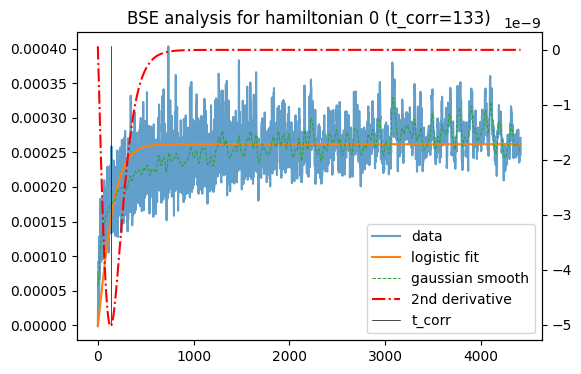

Correlation time for set 0 is 133


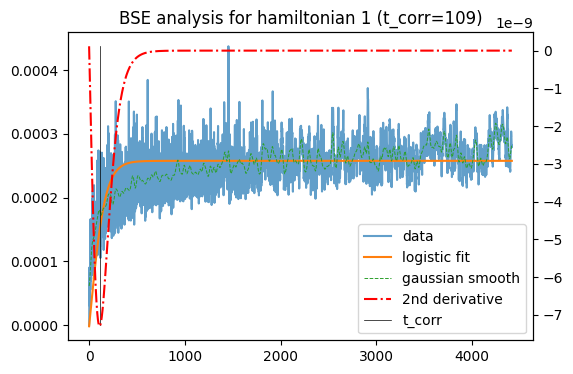

Correlation time for set 1 is 109


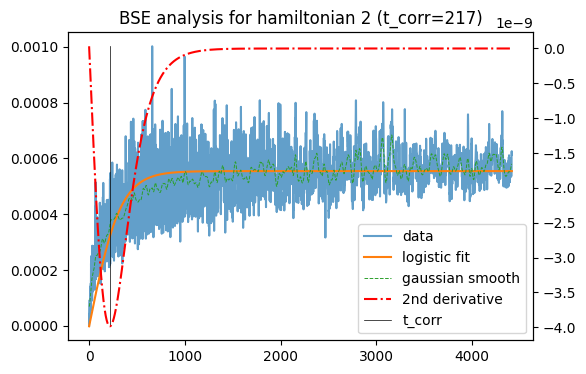

Correlation time for set 2 is 217


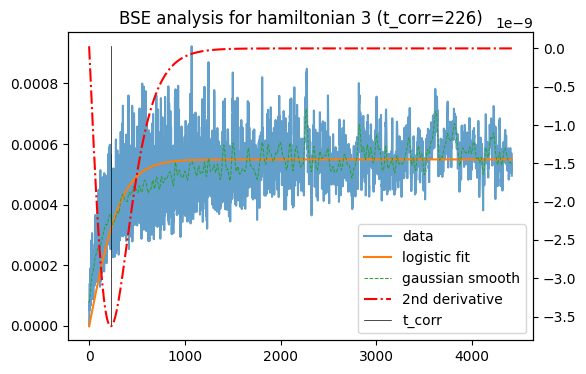

Correlation time for set 3 is 226


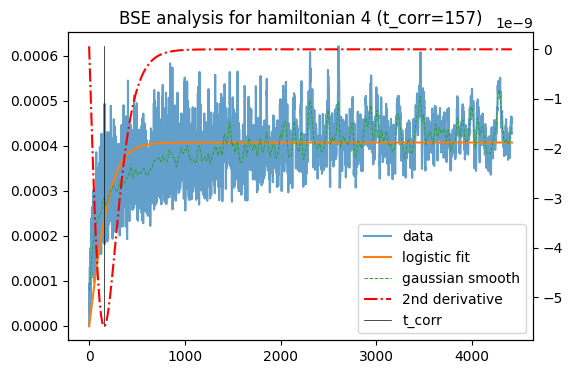

Correlation time for set 4 is 157


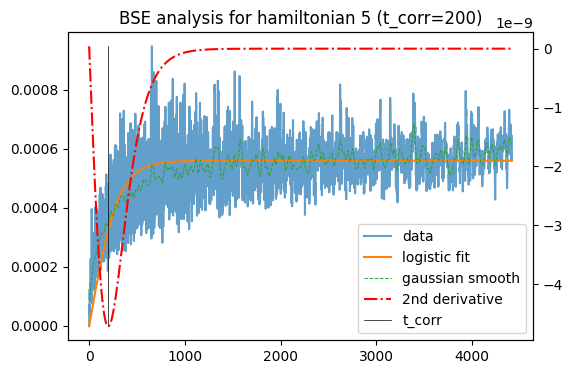

Correlation time for set 5 is 200


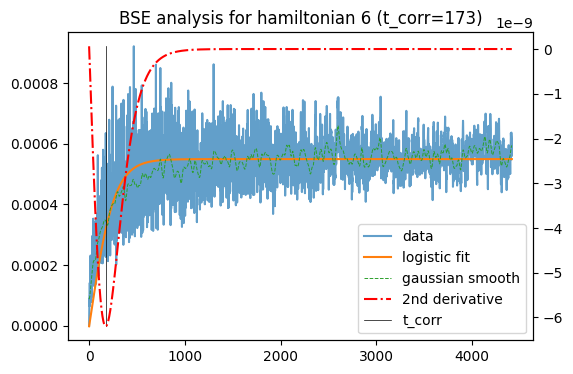

Correlation time for set 6 is 173


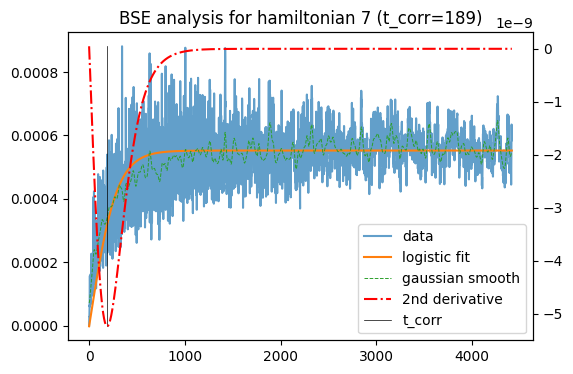

Correlation time for set 7 is 189


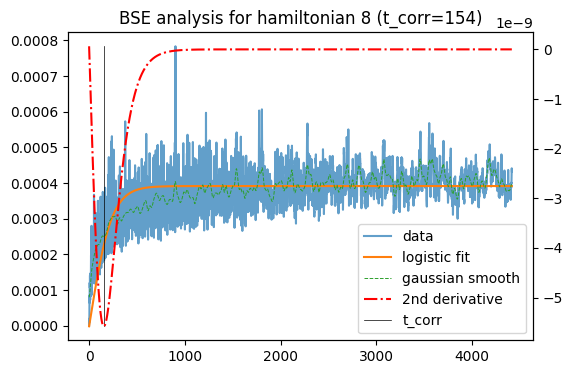

Correlation time for set 8 is 154


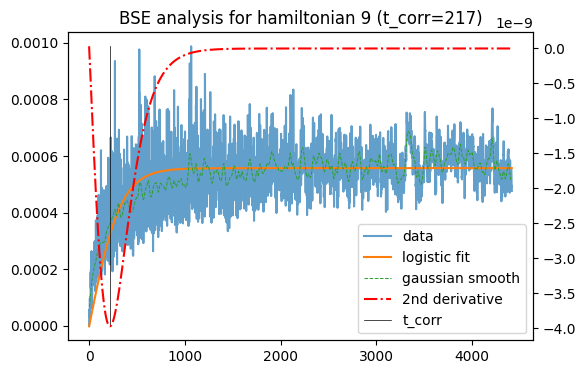

Correlation time for set 9 is 217


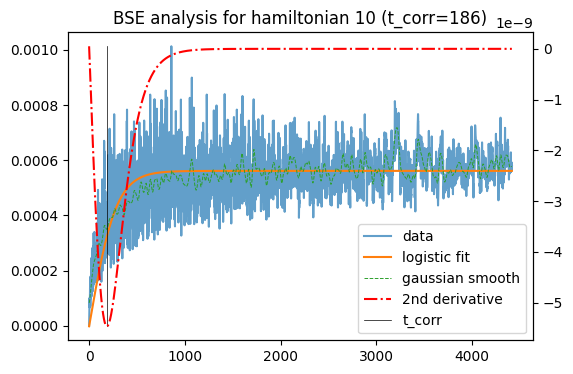

Correlation time for set 10 is 186


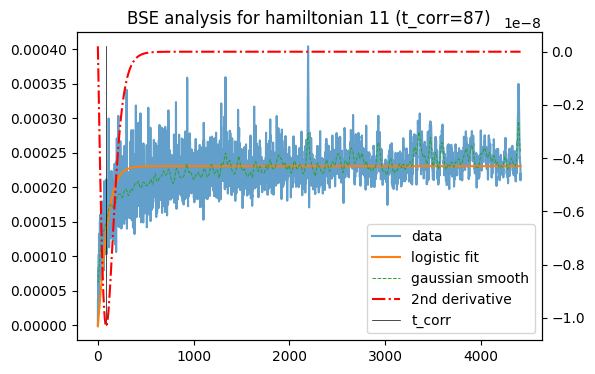

Correlation time for set 11 is 87


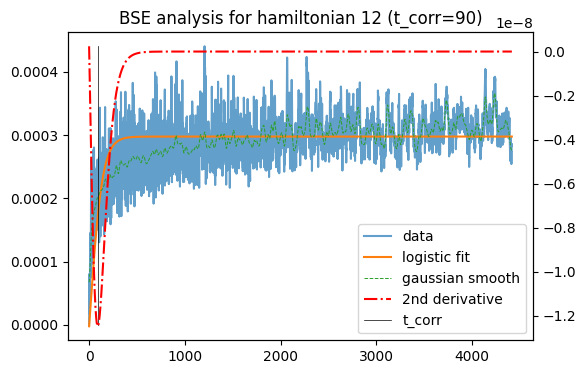

Correlation time for set 12 is 90


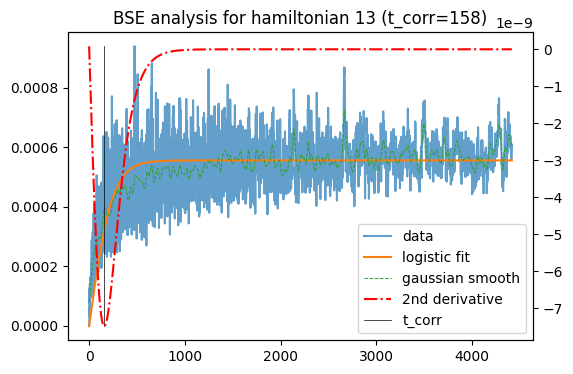

Correlation time for set 13 is 158


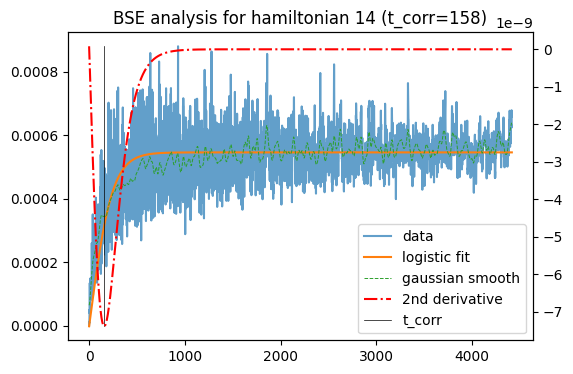

Correlation time for set 14 is 158


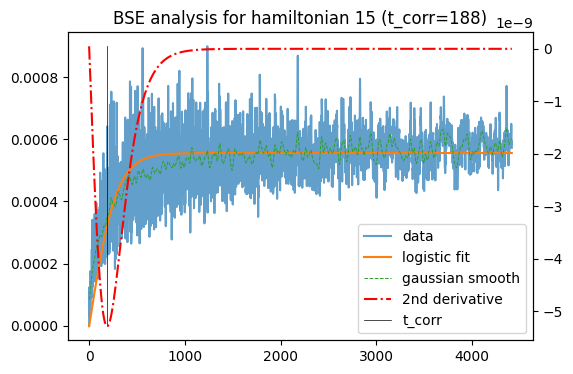

Correlation time for set 15 is 188


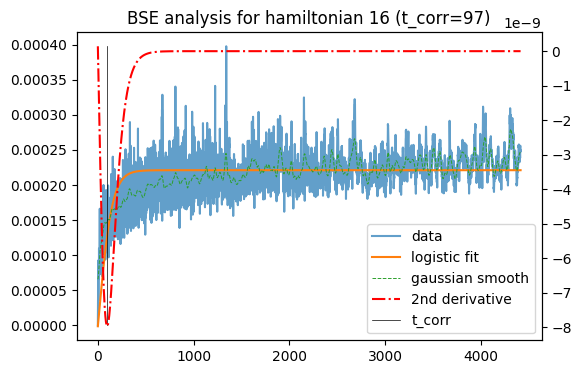

Correlation time for set 16 is 97


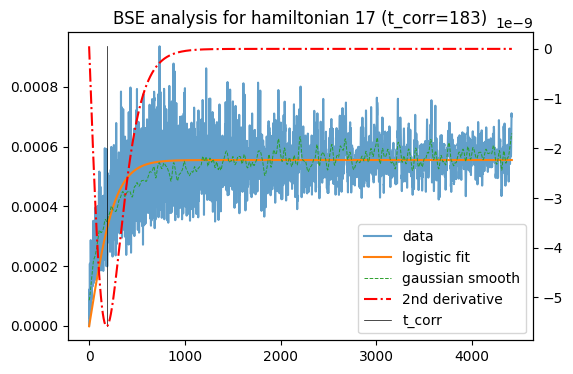

Correlation time for set 17 is 183


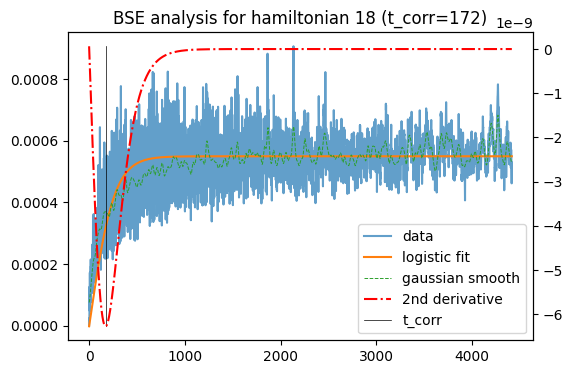

Correlation time for set 18 is 172


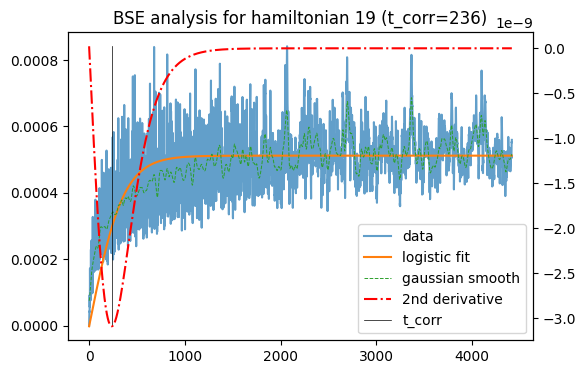

Correlation time for set 19 is 236


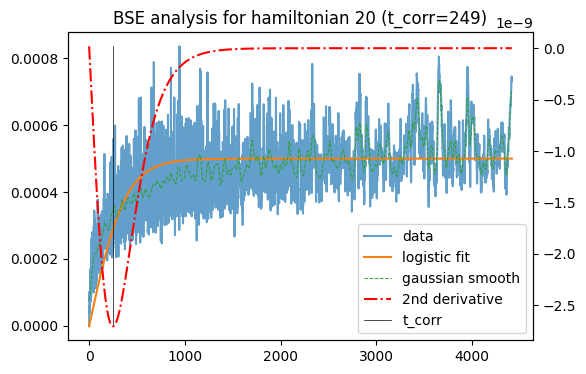

Correlation time for set 20 is 249


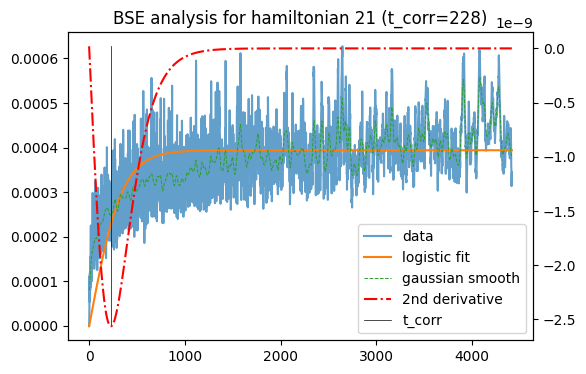

Correlation time for set 21 is 228


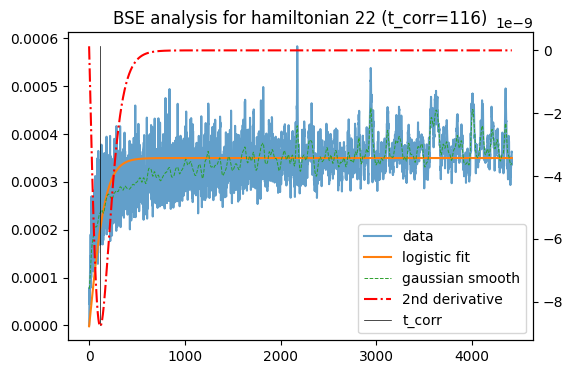

Correlation time for set 22 is 116


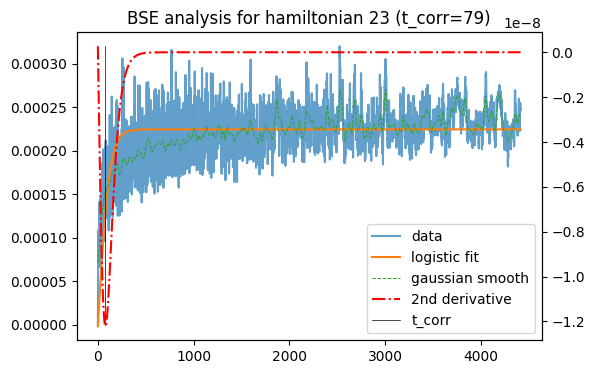

Correlation time for set 23 is 79


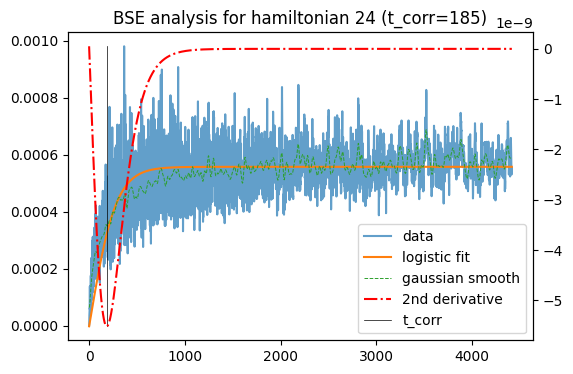

Correlation time for set 24 is 185


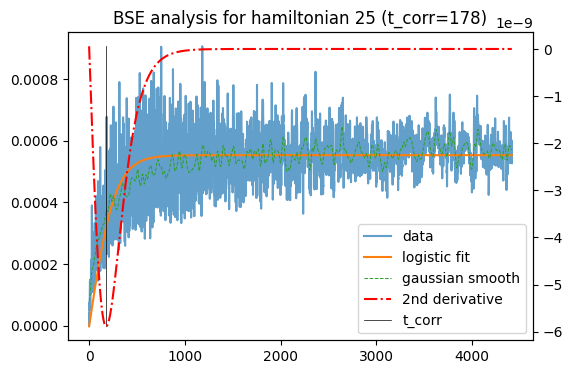

Correlation time for set 25 is 178


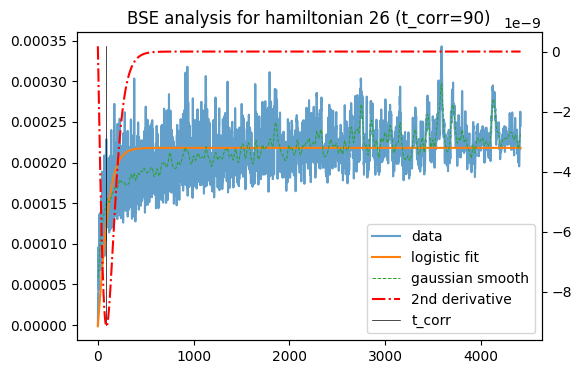

Correlation time for set 26 is 90


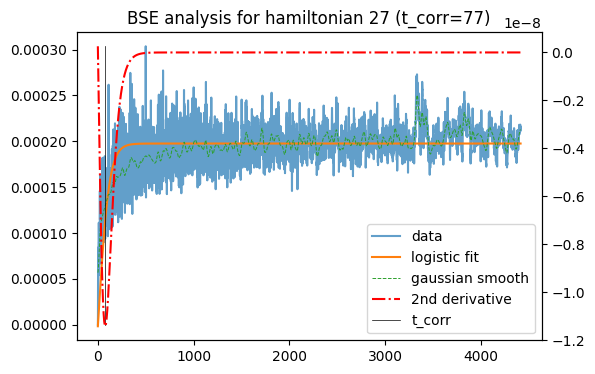

Correlation time for set 27 is 77


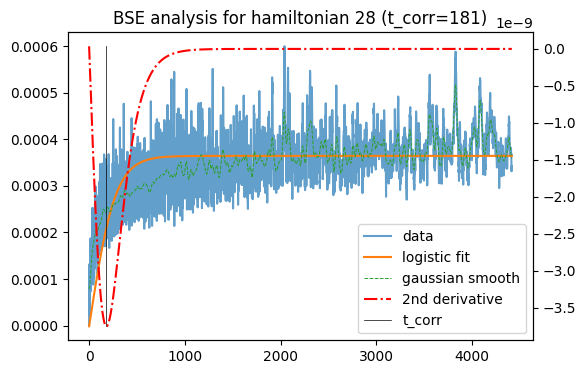

Correlation time for set 28 is 181


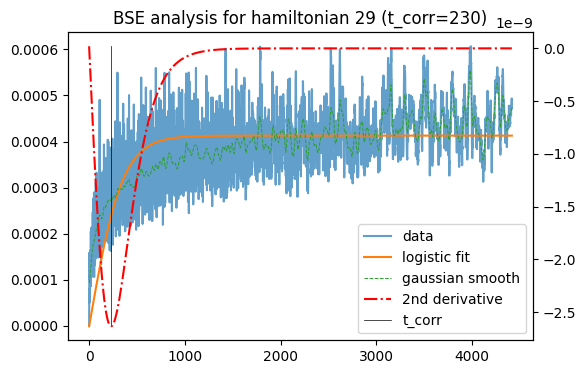

Correlation time for set 29 is 230


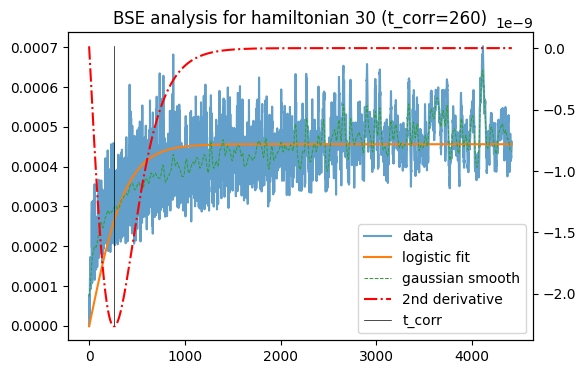

Correlation time for set 30 is 260


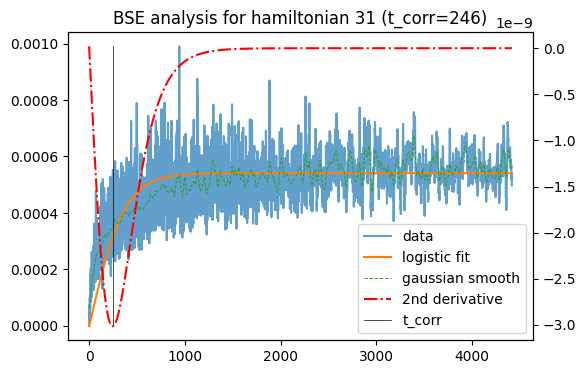

Correlation time for set 31 is 246


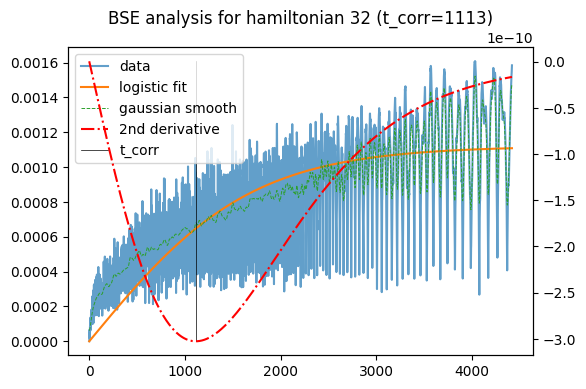

Correlation time for set 32 is 1113


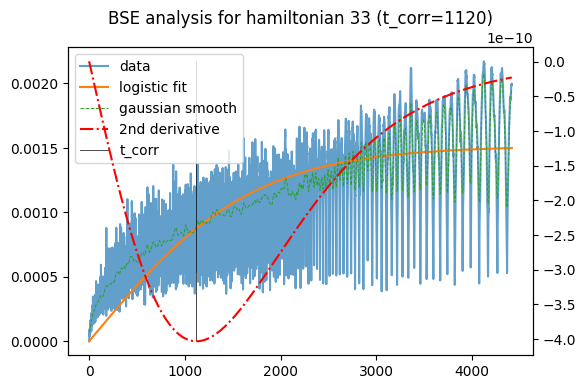

Correlation time for set 33 is 1120


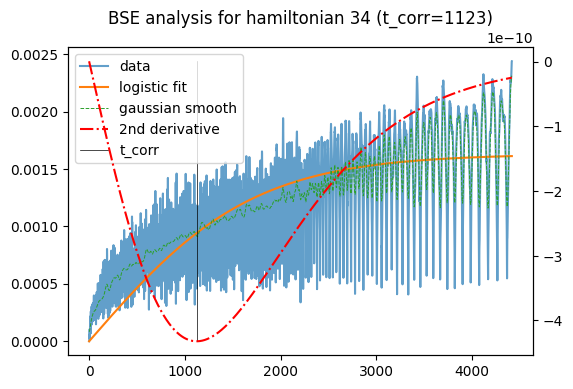

Correlation time for set 34 is 1123


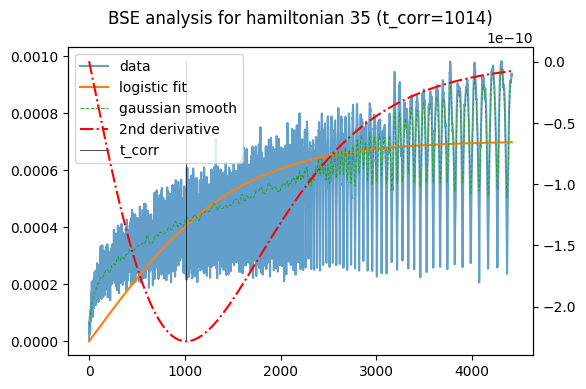

Correlation time for set 35 is 1014


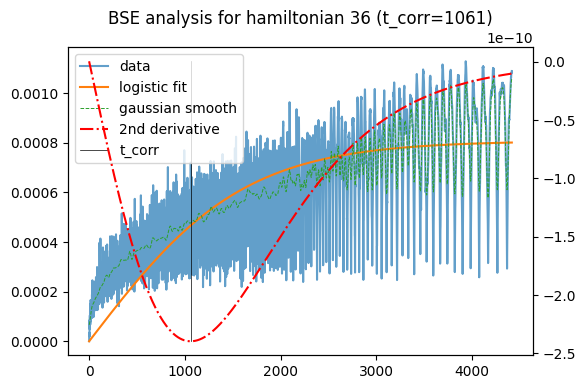

Correlation time for set 36 is 1061


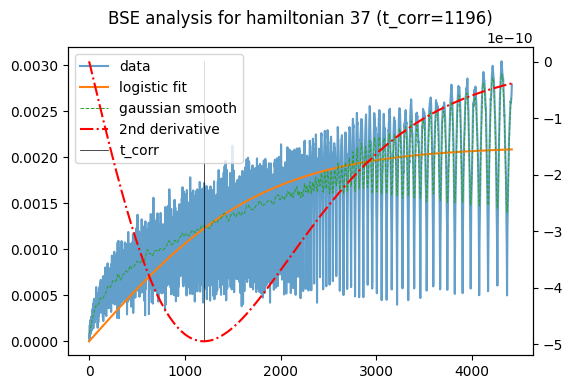

Correlation time for set 37 is 1196


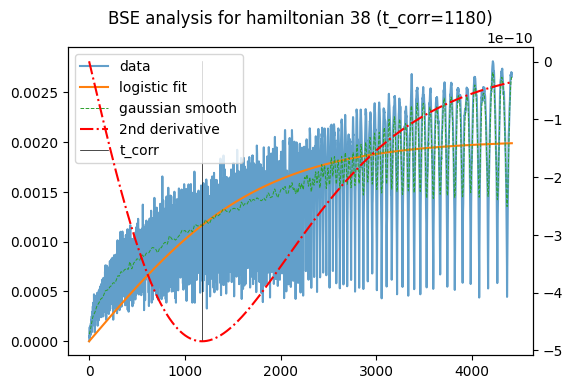

Correlation time for set 38 is 1180


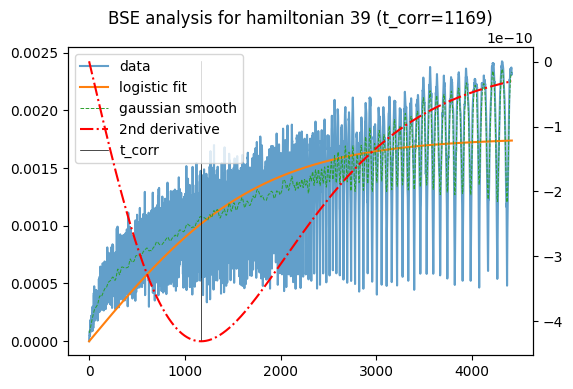

Correlation time for set 39 is 1169


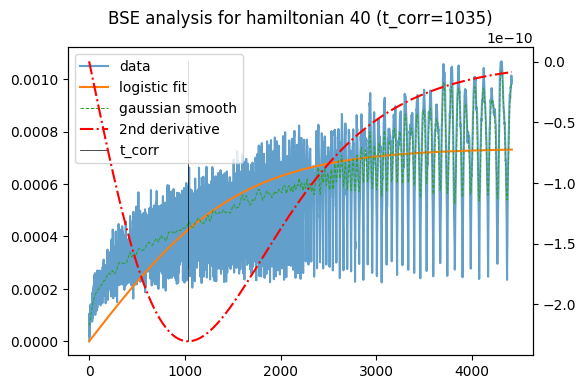

Correlation time for set 40 is 1035


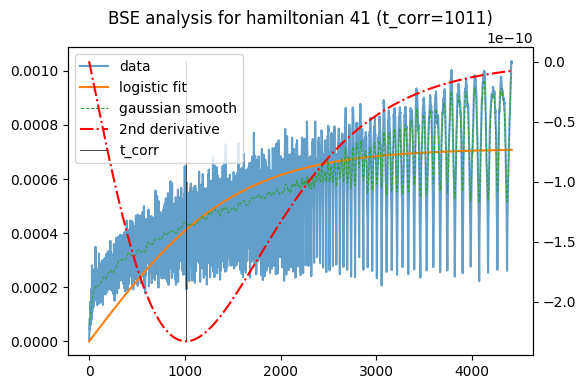

Correlation time for set 41 is 1011


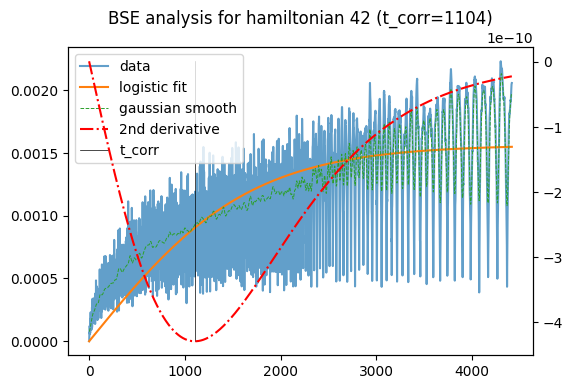

Correlation time for set 42 is 1104


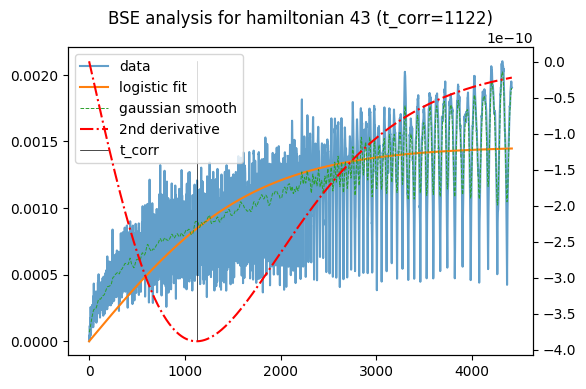

Correlation time for set 43 is 1122


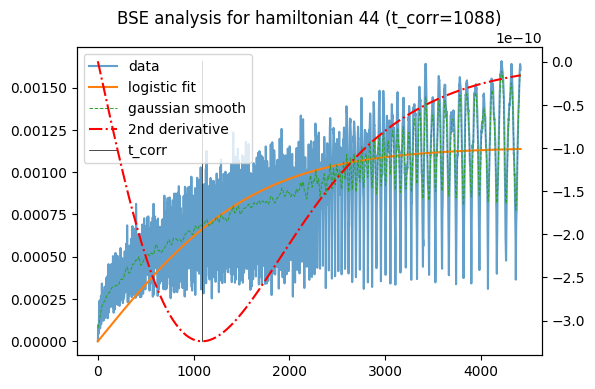

Correlation time for set 44 is 1088


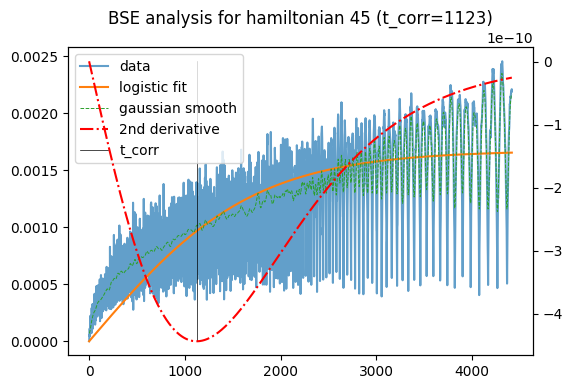

Correlation time for set 45 is 1123


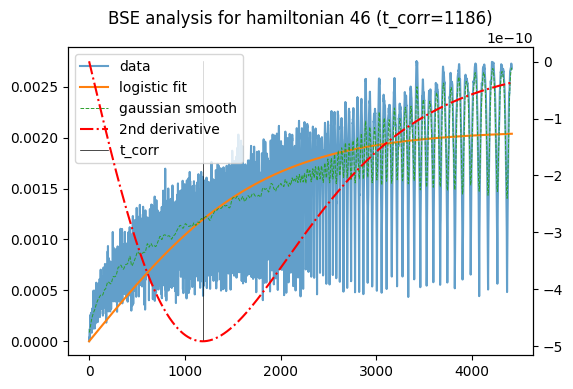

Correlation time for set 46 is 1186


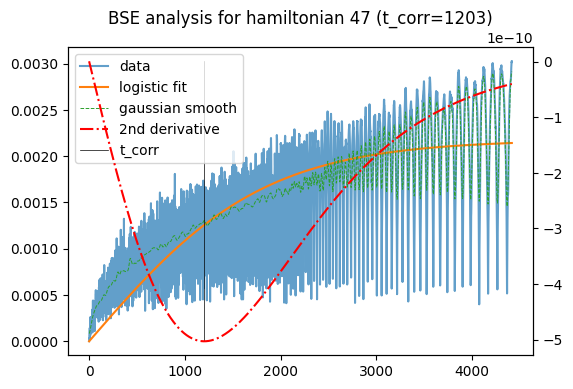

Correlation time for set 47 is 1203


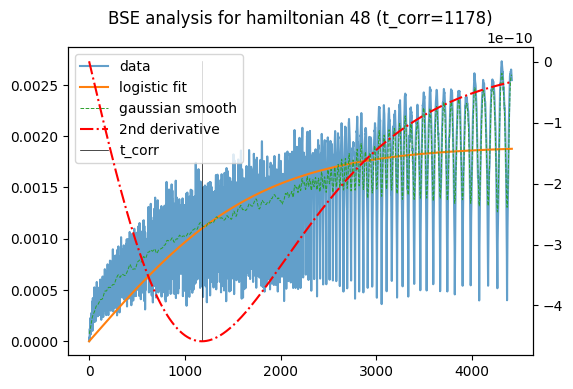

Correlation time for set 48 is 1178


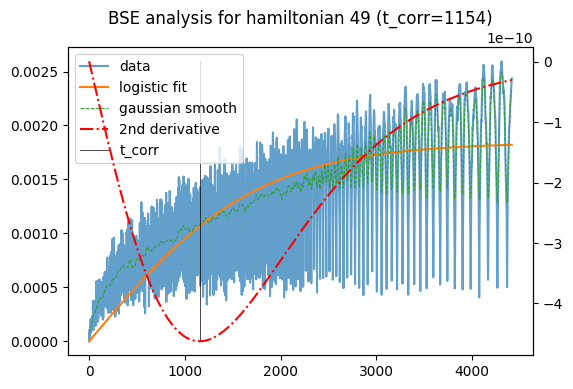

Correlation time for set 49 is 1154


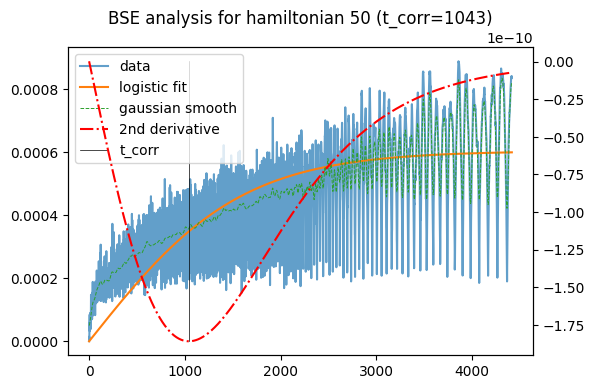

Correlation time for set 50 is 1043


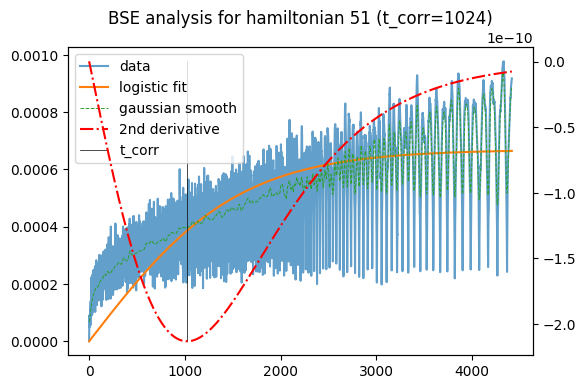

Correlation time for set 51 is 1024


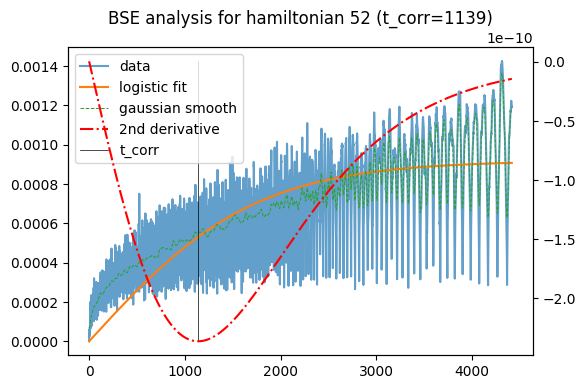

Correlation time for set 52 is 1139


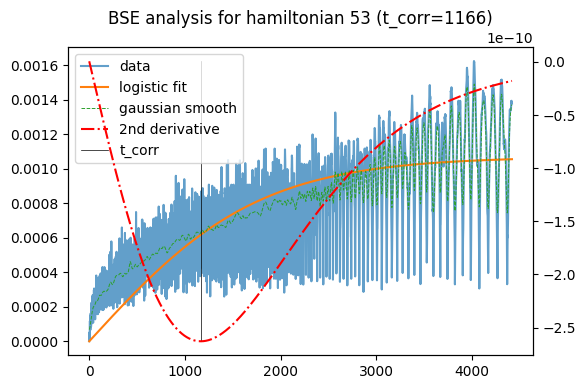

Correlation time for set 53 is 1166


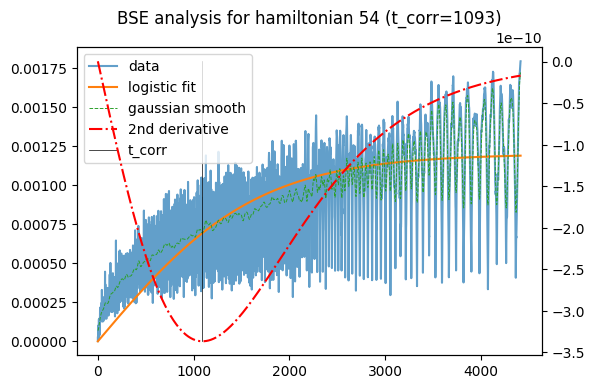

Correlation time for set 54 is 1093


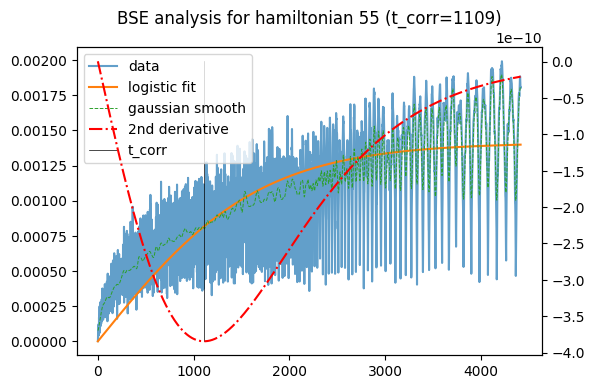

Correlation time for set 55 is 1109


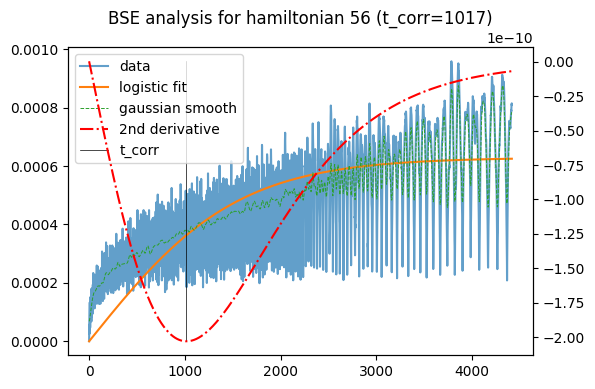

Correlation time for set 56 is 1017


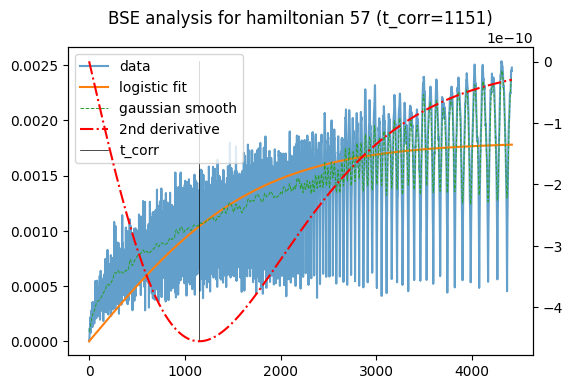

Correlation time for set 57 is 1151


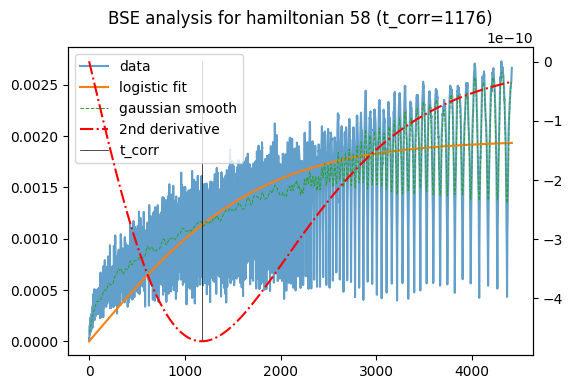

Correlation time for set 58 is 1176


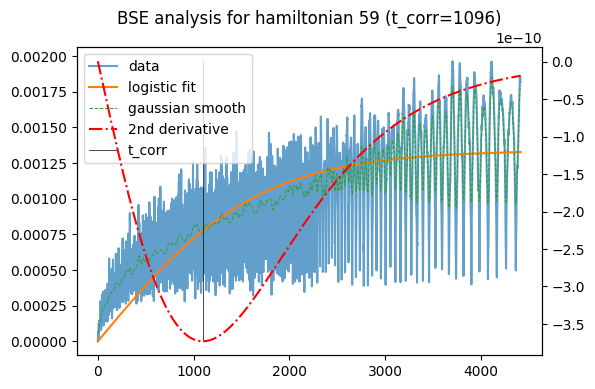

Correlation time for set 59 is 1096


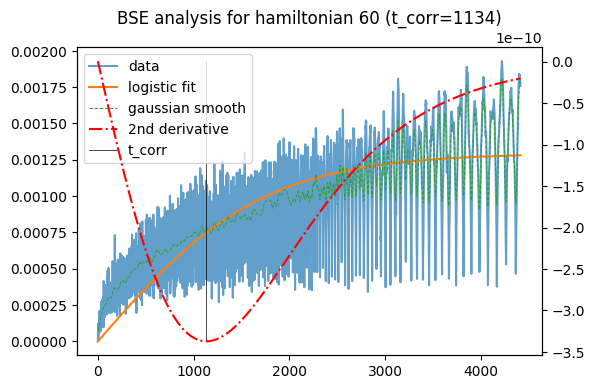

Correlation time for set 60 is 1134


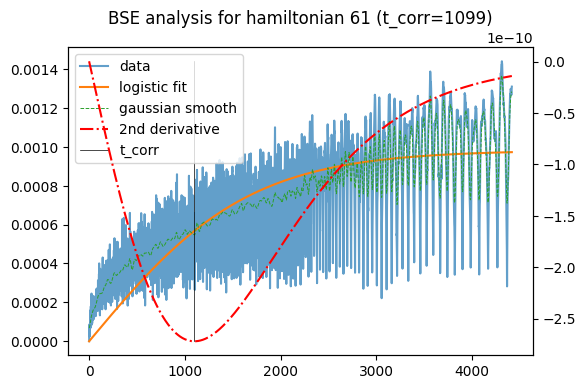

Correlation time for set 61 is 1099


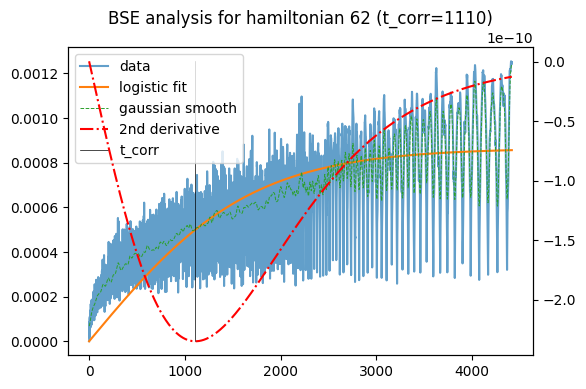

Correlation time for set 62 is 1110


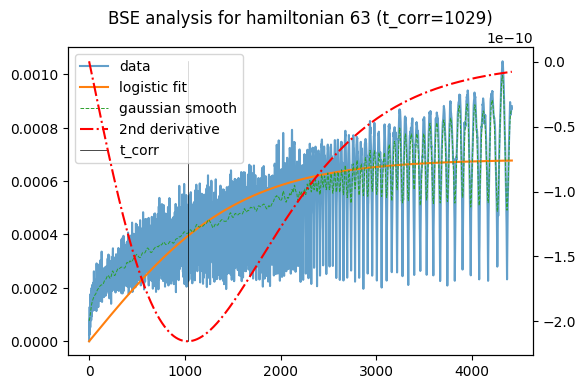

Correlation time for set 63 is 1029


FES succesfully calculated


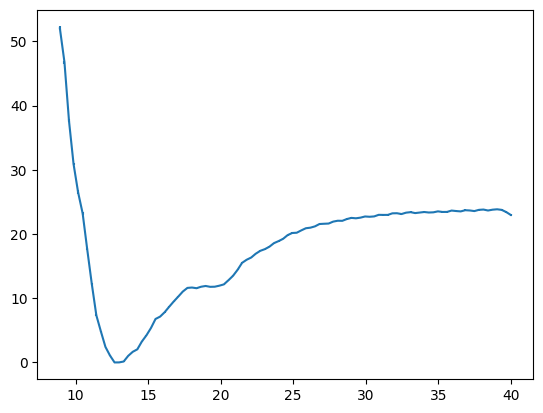

(array([ 8.917,  9.231,  9.545,  9.859, 10.173, 10.487, 10.801, 11.115,
        11.429, 11.743, 12.057, 12.371, 12.685, 12.999, 13.313, 13.627,
        13.941, 14.255, 14.569, 14.883, 15.197, 15.511, 15.825, 16.139,
        16.453, 16.767, 17.081, 17.395, 17.709, 18.023, 18.337, 18.651,
        18.965, 19.279, 19.593, 19.907, 20.221, 20.535, 20.849, 21.163,
        21.477, 21.791, 22.105, 22.419, 22.733, 23.047, 23.361, 23.675,
        23.989, 24.303, 24.617, 24.931, 25.245, 25.559, 25.873, 26.187,
        26.501, 26.815, 27.129, 27.443, 27.757, 28.071, 28.385, 28.699,
        29.013, 29.327, 29.641, 29.955, 30.269, 30.583, 30.897, 31.211,
        31.525, 31.839, 32.153, 32.467, 32.781, 33.095, 33.409, 33.723,
        34.037, 34.351, 34.665, 34.979, 35.293, 35.607, 35.921, 36.235,
        36.549, 36.863, 37.177, 37.491, 37.805, 38.119, 38.433, 38.747,
        39.061, 39.375, 39.689, 40.003]),
 array([5.20151215e+01, 4.67684611e+01, 3.76097525e+01, 3.08992562e+01,
        2.64878407e+01

In [7]:
# energies_US.decorr_cv_H(min_indep_cvs=1000, t_corr=100, show=False)
# print(energies_US.nsamples_H)
# t_corr=100
energies_US.calc_free_energies(decorr=True,min_indep_cvs=100)
energies_US.plot_PMF()

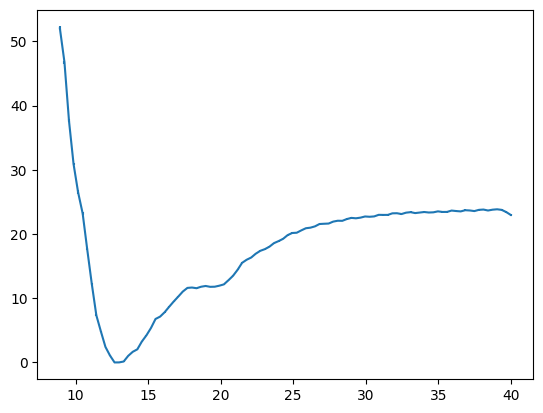

In [12]:
def create_PMF(self, show_pmf=True):
        u_H = self.beta_H[:,None] * self.cvK_H[:, None] * (self.cvs_H[:,:] - self.cv0_H[:,None])**2
        u_H -= u_H.min()
        self.fes.generate_fes(u_H, self.cvs, fes_type="histogram", histogram_parameters=self.histo_params)
        results = self.fes.get_fes(self.bin_centers, reference_point="from-lowest", uncertainty_method="analytical")
        center_f_i = results["f_i"]
        center_df_i = results["df_i"]
        x = self.bin_centers
        y = center_f_i*self.kB*self.T/2
        yerr = center_df_i*self.kB*self.T/2


        plt.errorbar(x, y, yerr=yerr)
        if show_pmf:
            plt.show()
        return x, y, yerr

comdist, F, dF = create_PMF(energies_US)

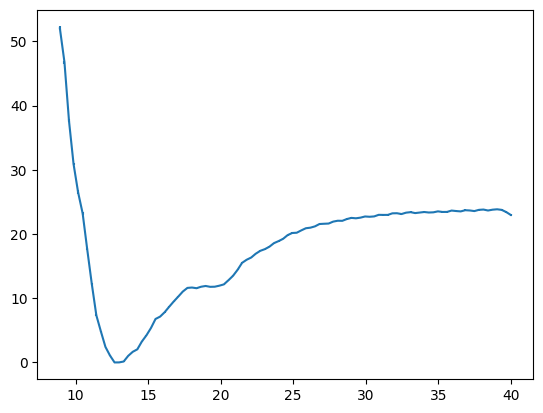

3.4097702658386092e+16

In [33]:
def calculate_I_star(self, site_r=None, show_pmf=True):
    
    if site_r==None:
        print("site_r is None but should be the cut-off, where binding site ends and the bulk region starts")
    
    comdist, F, dF = create_PMF(self, show_pmf=show_pmf)
    site_id = np.where(comdist > site_r)[0][0]
    comdist[site_id]

    W_site = F[site_id]
    W_PMF = F[:site_id]

    integrand = np.exp(-np.mean(self.beta_H)*(W_PMF - W_site))
    I_star = integrate.trapz(integrand, self.bin_centers[:site_id])
    setattr(self,'I_star', I_star)
    

calculate_I_star(energies_US, site_r=30, show_pmf=True)

In [67]:
from scipy import integrate
import math
import numpy as np


site_r = 30
def integrand(theta, phi):
        
        k_phi = 100.0
        k_theta = 100.0
        
        theta0 = 1.27
        phi0 = -2.89
        
        u_theta = k_theta * (theta0 - theta)**2
        u_phi = k_phi * (phi0 - phi)**2
        
        return( math.sin(theta) * math.exp(-energies_US.beta_H[0] * (u_theta + u_phi)))

result, error = integrate.nquad(integrand, [[0, math.pi],
                                            [-math.pi,math.pi]])
S_star = site_r**2*result
dS_star = site_r**2*error




In [72]:
S_star * energies_US.I_star

5.48128449251595e+17

In [ ]:
### Early attempts on optimising the calc_free_energies stuff. In the remedeed by specifiying solver_protocol
# %%time
# fileglob = '../_sim/07_TIP3P_med_HREUS_K=4/_output/pmd_prod_hreus*.txt'

# energies_US = AmbeRouxWoo_I_contrib(fileglob, 8, 300, 100)
# energies_US.read_cvdata_from_pmdout()
# energies_US.nsamples_H
# energies_US.decorr_cv_H(t_corr=100, show=False)
# energies_US.nsamples_H
# # energies_US.calc_free_energies()
# # energies_US.plot_PMF()
# energies_US.nsamples_H
# %%time
# fileglob = '../_sim/07_TIP3P_med_HREUS_K=4/_output/pmd_prod_hreus*.txt'

# energies_US = AmbeRouxWoo_I_contrib(fileglob, 8, 300, 100)
# energies_US.read_cvdata_from_pmdout()
# energies_US.decorr_cv_H(t_corr=10, show=False)
# energies_US.calc_free_energies()
# energies_US.plot_PMF()
# energies_US.nsamples_H
# %%time
# energies_US.calc_free_energies()
# %%time
# energies_US.plot_PMF()
# %%time
# energies_US.plot_PMF()

In [120]:
# %%time
# u_H = energies_US.beta_H[:,None] * energies_US.cvK_H[:, None] * (energies_US.cvs_H[:,:] - energies_US.cv0_H[:,None])**2
# u_H -= u_H.min()
    
# samplesize=10000
# stride=5000

# samplesizes = np.array([samplesize]*energies_US.cvs_H.shape[0])

# step_max = (energies_US.cvs_H.shape[1]-samplesize)/stride



# for step in range(int(step_max)+1):
#     b = step * stride
#     e = step * stride + samplesize
# #     print(energies_US.cvs_H[:,b:e].shape,samplesizes)
    
#     energies_US.calc_free_energies(b=b,e=e)
    
#     energies_US.fes.generate_fes(u_H[:,b:e], energies_US.cvs, fes_type="histogram", histogram_parameters=energies_US.histo_params)
    
#     results = energies_US.fes.get_fes(energies_US.bin_centers, reference_point="from-lowest", uncertainty_method="analytical")
#     center_f_i = results["f_i"]
#     center_df_i = results["df_i"]
#     plt.scatter(energies_US.bin_centers, center_f_i*energies_US.kB*energies_US.T/2)

# plt.show()

In [ ]:
# BAR is too tedious to set up without knowing that it will do me any benefit
# %%time
# mbar_options={"initialize":"BAR"}
# mbar_options['initialize']
# u_HR = energies_US.beta_H[None,:,None] * energies_US.cvK_H[None,:, None] * (energies_US.cvs_H[:,None,:] - energies_US.cv0_H[:,None])**2
# w_F = np.zeros((31,50000))
# w_R = np.zeros((31,50000))

# for i in range(32-1):
#     j=i+1
#     w_F[i,:] = u_HR[i,j,:] - u_HR[i,i,:]
        
# for i in range(1,32):
#     j=i-1
#     w_R[j,:] = u_HR[j,i,:] - u_HR[i,i,:]
# w_F,w_R

# pymbar.other_estimators.bar(w_F,w_R)
# # pymbar.FES(u_HR, energies_US.nsamples_H, verbose=True)

In [ ]:
### failed attempt top get naive convergence plots. Didnt work because self.fes uses too many attributes

# u_H = energies_US.beta_H[:,None] * energies_US.cvK_H[:, None] * (energies_US.cvs_H[:,:] - energies_US.cv0_H[:,None])**2
# u_H -= u_H.min()
        

# samplesize=10000
# stride=5000

# samplesizes = np.array([samplesize]*energies_US.cvs_H.shape[0])

# step_max = (energies_US.cvs_H.shape[1]-samplesize)/stride



# for step in range(int(step_max)+1):
#     b = 0
#     e = -1
#     print(energies_US.cvs_H[:,b:e].shape,samplesizes)
#     cv_samples = pymbar.utils.kn_to_n(energies_US.cvs_H[:,b:e], N_k=samplesizes)
#     energies_US.fes.generate_fes(u_H[:,b:e], cv_samples, fes_type="histogram", histogram_parameters=energies_US.histo_params)
    
# # energies_US.cvs_H[:,b:e].shape

# Look at the MBAR publication for Safety tests

In [ ]:
### Early tries to calculate the FES. Redundant by now

# fileglob = '../_sim/07_TIP3P_med_HREUS_K=4/_output/pmd_prod_hreus*.txt'

# FE_07 = AmbeRouxWoo_I_contrib(fileglob, 8, 300, 100)
# FE_07.read_cvdata_from_pmdout()
# FE_07.plot_us_histograms()

# results = FE_07.fes.get_fes(FE_07.bin_centers, reference_point="from-lowest", uncertainty_method="analytical")
# center_f_i = results["f_i"]
# center_df_i = results["df_i"]
# FE_07.T = 300
# plt.scatter(FE_07.bin_centers, center_f_i*FE_07.kB*FE_07.T/2,)

In [ ]:
### Early attempt on a fileparser. By now deprecated due do the class method read_pmd blablabla
# ### set the file path and from there generate K as the count of replicas, the column might be able to be 
# ### read in from file or priorly from the code suite
# files = glob('../_sim/04_TIP3P_med_HREUS_32reps/_output/pmd_prod_hreus*.txt')
# K = len(files)
# col=8
# ### rename k to rep??
# # Temperature and beta of replica k
# T_k = np.ones(K,float)*T 
# beta_k = 1.0 / (kB * T_k)
# # regexp suitaable for the NFE PMD simulation output file; maybe pick better names for regexp1,2
# regexp1 = re.compile(r'anchor\({}\).* position = \d*.\d+,\s+(\d*.\d*),\s+(\d*.\d+),\s+\d*.\d+'.format(col))
# regexp2 = re.compile(r'strength = (\d*.\d+),\s+(\d*.\d*)')

# # spring contant and spring centers being initiailisedd for each replica k element of K
# Kd_k = np.zeros([K], np.float64) 
# d0_k = np.zeros([K], np.float64)
# # probably the distance of each replica
# d_k = []
# minlist = []
# maxlist = []

# # iterate through files to read the meta data (centers and spring constants)
# for k, file in enumerate(files):
#     # read the file and try to find the regex expression in each line
#     with open(file) as fn:
#         for line in fn:
#             try:
#                 # centers are read in; from first regexp and the spring constant from second regexp
#                 r2,r3 = re.search(regexp1, line).group(1,2)
#                 k1,k2 = re.search(regexp2, next(fn)).group(1,2)
#                 # arrays are filled per assignment... list.append -> np.array(list) is a bit better imo
#                 d0_k[k] = float(r2)
#                 Kd_k[k] = float(k1)
#                 # when the array elements are set succesfully the file is done meta data wise -> break
#                 break
#             except AttributeError:
#                 # I forgot why this was important...
#                 pass
#         # ofc r2 must be r3 otherwise it is not true umbrella sampling 
#         if r2 != r3 or k1 != k2:
#             raise ValueError('the reference positions r2, r3 or the force constants of each harmonic restraint contribution are not identical. WHAM only works for harmonic restraints. ')
    
#     # the numerical data is read in via pd read_csv, here col is importatnt
#     dcom_data = pd.read_csv(file, delim_whitespace=True, comment='#', header=None, usecols=[0,col])
#     d_k.append(dcom_data.loc[:,col].values)
    
#     # get the highest and lowest values of the numerical data
#     minlist.append(dcom_data.loc[:,col].values.min())
#     maxlist.append(dcom_data.loc[:,col].values.max())

# # stack the arrays in the d_k list; d_kn means the values for replica k are in the first dimension 
# # and the replicas are saved in the second dimension 'n'. 
# ### stupid name. should be called d_reps or something like this. or cv_rep
# d_kn = np.stack(d_k, axis=0)


# # lets rename chi to d! the minimum and maximum values are here saved for the FE analysis for later
# d_max = np.ceil(np.array(maxlist).max())
# d_min = np.floor(np.array(minlist).min())

In [ ]:
# for i,_ in enumerate(d_kn):
    
#     g_d = timeseries.statistical_inefficiency(d_kn[i])
#     print(f"g_d = {g_d:.1f} | g_d = {g_d:.1f}")
#     g_k = max(g_d, g_d)
#     print(f"Correlation time for set {k:5d} is {g_k:10.3f}")
#     indices = timeseries.subsample_correlated_data(d_kn[i], g=g_k)
    
#     N_k[i] = len(indices)
#     d_kn[i, 0 : N_k[i]] = d_kn[i, indices]

In [ ]:
### Early attempts to calculate the FES
# # Set zero of u_kn -- this is arbitrary.
# u_kn -= u_kn.min()

# # compute bin centers
# bin_center_i = np.zeros([nbins])
# bin_edges = np.linspace(d_min+0.5, d_max-0.5, nbins + 1)
# for i in range(nbins):
#     bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])

# N = np.sum(N_k)
# d_n = pymbar.utils.kn_to_n(d_kn, N_k=N_k)

# histogram_parameters = {}
# histogram_data = {}
# histogram_parameters["bin_edges"] = bin_edges

# fes.generate_fes(u_kn, d_n, fes_type="histogram", histogram_parameters=histogram_parameters)


In [ ]:
### Comparison whith the whamout of that simulation set
# df1 = pd.read_csv('../_sim/04_TIP3P_med_HREUS_32reps/whamout', delim_whitespace=True, comment='#', header=None)
# df2 = pd.read_csv('../_sim/02_TIP3P_med_HREUS/whamout', delim_whitespace=True, comment='#', header=None)
# plt.plot(df1.iloc[:,0], df1.iloc[:,1])
# plt.plot(df2.iloc[:,0], df2.iloc[:,1])
# plt.plot(bin_center_i,center_f_i*kB*T/2,)

In [ ]:
# def AmberUS_FE_estimator():

# # 1. Declare lots of Variables (some might be set)

#     kB = 0.001987204259     # kB in kcal/mol/K ambers standard energy unit
    
#     def __init__(self, fileglob, cv_col, T):
#         self.files = glob(self.fileglob)    # fileglob can also be a single file
#         self.H = len(self.files)            # H: number of different hamiltonians 1,...,h element of H
#         self.T_H = np.ones(H,float)*T       # T can either be a scalar or vector of size wins
#         self.cv_col = cv_col                # column in pmd out file with the data of collective variable
#         self.beta_H = 1.0 / (kB * self.T_H) # just for convenience, beta is also calculated
#         self.cv0_ex = re.compile(r'anchor\({}\).* position = \d*.\d+,\s+(\d*.\d*),\s+(\d*.\d+),\s+\d*.\d+'.format(self.cv_col))
#         self.cvK_ex = re.compile(r'strength = (\d*.\d+),\s+(\d*.\d*)')
#         self.cvK_H = np.zeros(H, np.float64) 
#         self.cv0_H = np.zeros(H, np.float64)
#         self.cvs_H = 0
#         self.cvmin = 0
#         self.cvmax = 0
        
# # 2. Read in data and meta data of files or Read in CV data
#     def read_cvdata_from_pmdout(self):
#         cvs = []
#         mins = []
#         maxs = []
#         # iterate through files to read the meta data (centers and spring constants)
#         for i, file in enumerate(self.files):
#             # read the file and try to find the regex expression in each line
#             with open(file) as fn:
#                 for line in fn:
#                     try:
#                         # centers are read in; from first regexp and the spring constant from second regexp
#                         r2,r3 = re.search(self.cv0_ex, line).group(1,2)
#                         k1,k2 = re.search(self.cvK_ex, next(fn)).group(1,2)
#                         # arrays are filled per assignment... list.append -> np.array(list) is a bit better imo
#                         cv0_H[i] = float(r2)
#                         cvK_H[i] = float(k1)
#                         # when the array elements are set succesfully the file is done meta data wise -> break
#                         break
#                     except AttributeError:
#                         # I forgot why this was important...
#                         pass
#                 # ofc r2 must be r3 otherwise it is not true umbrella sampling 
#                 if r2 != r3 or k1 != k2:
#                     raise ValueError('the reference positions r2, r3 or the force constants of each harmonic restraint contribution are not identical. WHAM only works for harmonic restraints. ')

#             # the numerical data is read in via pd read_csv, here col is important
#             cv_df = pd.read_csv(file, delim_whitespace=True, comment='#', header=None, usecols=[0,self.col])
#             cvs.append(cv_df.loc[:,self.col].values)

#             # get the highest and lowest values of the numerical data
#             mins.append(cv_df.loc[:,self.col].values.min())
#             maxs.append(cv_df.loc[:,self.col].values.max())

#         # stack the arrays in the cvs list; cvs_H means the cv values (1dim) for all H hamiltonians (0dim) 
#         self.cvs_H = np.stack(self.cvs, axis=0)
#         self.nsamples_H = np.array([cvs.shape[0] for cvs in self.cvs_H])
#         # The minimum and maximum values are here saved for the FE analysis for later
#         self.cvmax = np.ceil(np.array(maxs).max())
#         self.cvmin = np.floor(np.array(mins).min())
        
# # 2.5 Decorrelate data
#     def decorr_cv_H(self):
#         self.nuncorr_H = self.nsamples_H
#         self.uncorr_H = self.cvs_H
        
#         for h in range(H):
#             t_corr = timeseries.statistical_inefficiency(cvs_H[h])
            
#             print(f"Correlation time = {.1f}".format(t_corr))
#             print(f"Correlation time for set {} is {}".format(h, t_corr))
            
#             ids = timeseries.subsample_correlated_data(cvs_H[h], g=t_corr)

#             self.nuncorr_H[h] = len(ids)
#             self.cvuncorr_H[h, 0 : samples_H[h]] = cvs_H[h, ids]
# # 3. calculate reduced energies
# # 4. create Histogram information
# # 5. Calculate FE
# # 6. Plot Stuff... not really necessary